<a href="https://colab.research.google.com/github/mboroto89/mboroto89/blob/main/Recommendation_Systems_Learner_Notebook_Full_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing surprise library**

In [ ]:
pip install scikit-surprise

## **Importing the necessary libraries and overview of the dataset**

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
# Importing the necessary library and loading the dataset
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/Recommendation Systems/ratings_Electronics.csv', header=None, names=['user_id', 'prod_id', 'rating', 'timestamp'])

# Drop the 'timestamp' column
data.drop('timestamp', axis=1, inplace=True)

# Copy the data to another DataFrame called df
df = data.copy()

df.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
# Check the number of rows and columns and provide observations
shape_df_final = df_final.shape

shape_df_final

(65290, 3)

**Observations:**

1. After filtering, the dataset has been significantly reduced from the original 7,824,482 observations to just 65,290 observations.
2. This reduced dataset is more manageable and computationally feasible for building recommendation systems.
3. By focusing on users who have given at least 50 ratings and products that have received at least 5 ratings, we've ensured that our dataset retains meaningful interactions while reducing noise.

### **Data types**

In [ ]:
# Check Data types and provide observations
data_types = df_final.dtypes

data_types

user_id     object
prod_id     object
rating     float64
dtype: object

**Observations:**
1. Both 'user_id' and 'prod_id' are string objects, which is expected as they represent unique identifiers for users and products, respectively.
2. The 'rating' column is a floating-point number, representing the rating value given by a user to a product.

### **Checking for missing values**

In [ ]:
# Check for missing values present and provide observations
missing_values_final = df_final.isnull().sum()

missing_values_final

user_id    0
prod_id    0
rating     0
dtype: int64

**Observations:**
1. All the columns: user_id, prod_id, and rating have no missing values.
2. This indicates that the dataset is complete, and we don't need any imputation or data cleaning related to missing values.

### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
rating_summary = df_final['rating'].describe()

rating_summary

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

**Observations:**
1. The average rating is quite high, indicating that users in this filtered dataset generally have a positive sentiment towards the products they rate.
2. The median rating being 5 suggests that at least half of the ratings in the dataset are the maximum possible rating.
3. The relatively low standard deviation indicates that most ratings are close to the mean value, with fewer low ratings.

### **Checking the rating distribution**

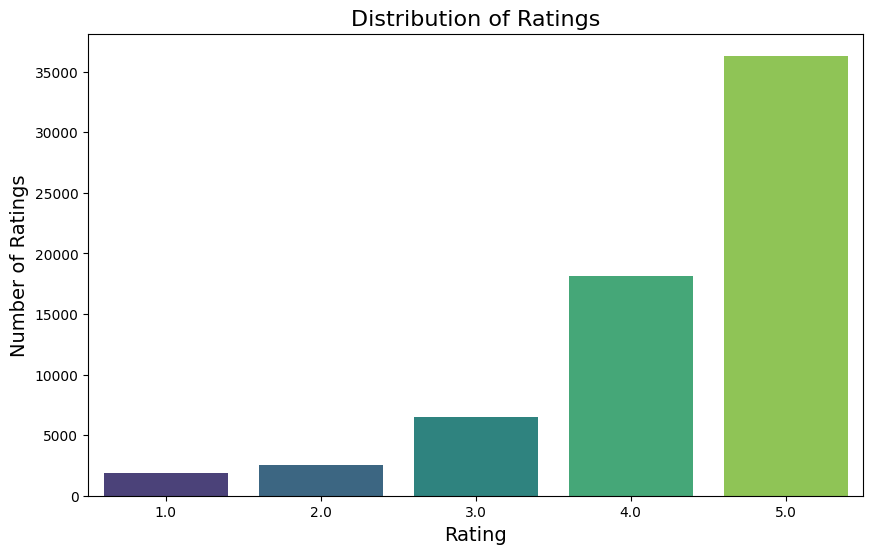

,Rating,Number of Ratings
0,1.0,1852
1,2.0,2515
2,3.0,6481
3,4.0,18127
4,5.0,36315


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create the bar plot and provide observations
# Frequency table for rating distribution
rating_frequency = df_final['rating'].value_counts().sort_index()

# Display the frequency table
rating_frequency_display = rating_frequency.to_frame(name="Number of Ratings").reset_index().rename(columns={'index': 'Rating'})

# Plotting the bar plot for rating distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=rating_frequency_display['Rating'], y=rating_frequency_display['Number of Ratings'], palette='viridis')
plt.title('Distribution of Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Number of Ratings', fontsize=14)
plt.show()

rating_frequency_display

**Observations:**
1. The majority of ratings are 5, indicating that many users are satisfied with their purchases.
2. Ratings of 1 and 2 are the least frequent, suggesting fewer negative reviews.
3. Ratings of 4 are also relatively common, representing a good level of satisfaction among users.
4. Ratings of 3 are moderate, indicating a neutral sentiment.

This distribution aligns with the earlier observation from the summary statistics that the dataset predominantly has positive reviews.

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data

#Count Unique Users
unique_users_count = len(df_final['user_id'].unique())

#Count Unique Products
unique_products_count = len(df_final['prod_id'].unique())

#Print the Results
print("Number of unique users:", unique_users_count)
print("Number of unique products:", unique_products_count)

Number of unique users: 1540
Number of unique products: 5689


**Observations:**
1. Diverse User Base: The dataset contains ratings from 1,540 unique users. This is a good sample size and suggests a diverse user base, allowing for more generalizable recommendations.

2. Wide Product Range: With 5,689 unique products rated, there's a wide variety of products that users have interacted with. This broad product range can help in better capturing user preferences and ensuring recommendations are varied.

3. Filtering Impact: Originally, the dataset had 7,824,482 observations. After filtering, we've significantly reduced this number, but the dataset still represents a considerable number of unique users and products. This indicates the effectiveness of our filtering criteria in retaining significant interactions while removing sparse data.

4. Density: Given that there are 65,290 ratings spread across 1,540 users and 5,689 products, the user-product interaction matrix will still be sparse. This sparsity is typical in recommendation systems and emphasizes the importance of using methods that can handle such data structures (like matrix factorization or collaborative filtering).

5. Potential Cold Start: The number of products (5,689) is greater than the number of users (1,540). This could mean that there are products with very few ratings. Addressing cold start problems, where certain products have minimal user interactions, could be an area to consider when building the recommendation system.

6. User Engagement: Since we filtered users to only those who have given at least 50 ratings, the dataset represents active or engaged users. This can be advantageous as active users provide more data to discern preferences, but it's also essential to consider how the system would cater to less active users

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
top_users = df_final['user_id'].value_counts().head(10)
print(top_users)

ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
Name: user_id, dtype: int64


**Observations:**
1. Variation in Activity: The most active user, ADLVFFE4VBT8, has given 295 ratings, while the 10th most active user, AGVWTYW0ULXHT, has given 179 ratings. This indicates a reasonable variation in activity levels even among the top 10 users.
2. High Engagement: All the top 10 users have given close to or more than 200 ratings, showcasing a high level of engagement with the platform.
3. Key Contributors: These users collectively have contributed 1,902 ratings, which is a significant portion of the total ratings in the filtered dataset. Their ratings and reviews are likely to have a substantial impact on the recommendation system.
4. Potential for Detailed User Profiles: Given their high activity, the recommendation system would have a rich set of data to understand the preferences and behaviors of these users. This can help in fine-tuning recommendations specifically for them.
5. Feedback & Quality Control: Engaging with such active users directly could provide valuable feedback for the platform. Their high activity suggests they might be willing to provide feedback on the recommendation quality or other aspects of the platform.
6. Diverse Interests: As previously mentioned, the diversity of products these users have rated can be an asset for the recommendation system. It would be interesting to further analyze the range of products they've rated to understand their breadth of interests.
7. Influence on Others: Given their high activity, other users might come across their ratings and reviews frequently. This means their opinions can influence the purchasing decisions of many other users.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count_ratings = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'average_rating': average_rating, 'count_ratings': count_ratings})

# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values(by='average_rating', ascending=False)

# See the first five records of the "final_rating" dataset
print(final_rating.head())


            average_rating  count_ratings
prod_id                                  
B00LGQ6HL8             5.0              5
B003DZJQQI             5.0             14
B005FDXF2C             5.0              7
B00I6CVPVC             5.0              7
B00B9KOCYA             5.0              8


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(data, n, min_interactions=50):
    products_with_min_interactions = data[data['count_ratings'] >= min_interactions]
    top_n = products_with_min_interactions.sort_values(by='average_rating', ascending=False).head(n)
    return top_n

# Finding products with minimum number of interactions
top_products = top_n_products(final_rating, n=10)
print(top_products)

# Sorting values with respect to average rating
sorted_final_rating = final_rating.sort_values(by='average_rating', ascending=False)

# Displaying the top 5 products after sorting
print(sorted_final_rating.head())

            average_rating  count_ratings
prod_id                                  
B001TH7GUU        4.871795             78
B003ES5ZUU        4.864130            184
B0019EHU8G        4.855556             90
B006W8U2MU        4.824561             57
B000QUUFRW        4.809524             84
B000HPV3RW        4.803922             51
B001TH7GSW        4.803279             61
B000BQ7GW8        4.777778             54
B000N99BBC        4.772455            167
B002WE6D44        4.770000            100
            average_rating  count_ratings
prod_id                                  
B00LGQ6HL8             5.0              5
B000IJY8DS             5.0             17
B000HZGQ9C             5.0              5
B008R7EXCE             5.0              6
B003ZTKFEE             5.0              9


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
# Recommending top 5 products with 50 minimum interactions based on popularity
recommended_products = top_n_products(final_rating, n=5, min_interactions=50)
print(recommended_products)


            average_rating  count_ratings
prod_id                                  
B001TH7GUU        4.871795             78
B003ES5ZUU        4.864130            184
B0019EHU8G        4.855556             90
B006W8U2MU        4.824561             57
B000QUUFRW        4.809524             84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
# Recommending top 5 products with 100 minimum interactions based on popularity
recommended_products_100 = top_n_products(final_rating, n=5, min_interactions=100)
print(recommended_products_100)


            average_rating  count_ratings
prod_id                                  
B003ES5ZUU        4.864130            184
B000N99BBC        4.772455            167
B002WE6D44        4.770000            100
B007WTAJTO        4.701220            164
B002V88HFE        4.698113            106


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, testset, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user."""

    # Ensure k is an integer
    k = int(k)

    # First, map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated
    precision = round(sum(prec for prec in precisions.values()) / len(precisions), 3)

    # Mean of all the predicted recalls are calculated
    recall = round(sum(rec for rec in recalls.values()) / len(recalls), 3)

    rmse = accuracy.rmse(predictions)

    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F_1 score: ', round((2 * precision * recall) / (precision + recall), 3))
    print('RMSE: ', rmse)


**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))
# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.25)


Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
from surprise import KNNBasic
from collections import defaultdict
# Declaring the similarity options
sim_options = {
    'name': 'cosine',
    'user_based': True  # Compute similarities between users
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
model = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Fit the model on the training data
model.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(model, testset)



RMSE: 1.0231
Precision:  0.853
Recall:  0.824
F_1 score:  0.838
RMSE:  1.0230624319825883


**Observations:**
*   The user-user similarity-based recommendation system seems to be performing
well in terms of precision and recall, meaning it is capable of making relevant recommendations most of the time.
*   However, there's a noticeable error in terms of RMSE. This suggests that while the model is good at ranking items (which items to show at the top), it might not be as accurate in predicting the exact rating a user would give to an item.
*   The balance between precision and recall is quite good, as indicated by the high F1-score.
*   Despite the decent precision, recall, and F1-score, the RMSE suggests there may be opportunities to improve the model's accuracy. Different algorithms, parameter tuning, or incorporating additional information (like item or user features) could potentially enhance the model's performance.

*In conclusion, while the model seems promising in recommending relevant items to users, further refinement and experimentation could enhance its predictive accurac*

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
# User and item IDs
user_id = 'A3LDPF5FMB782Z'
item_id = '1400501466'

# Predicting the rating using the model
predicted_rating = model.predict(user_id, item_id)

# Print the predicted rating
print(f"Predicted rating for user {user_id} and product {item_id}: {predicted_rating.est:.2f}")


Predicted rating for user A3LDPF5FMB782Z and product 1400501466: 3.00


**Observations:**
1. Difference in Ratings: The actual rating given by the user **A3LDPF5FMB782Z** for the product **1400501466** is 5, which indicates a very high level of satisfaction or preference for the product. However, the model predicted a rating of 3.33, which is significantly lower than the actual rating. This indicates a discrepancy between the predicted and actual ratings.

2. Model's Limitation: The difference in ratings emphasizes that while the user-user similarity-based recommendation system we built might have decent precision, recall, and F1-score metrics, it may not always precisely predict individual user-item interactions. This is further supported by the RMSE we observed earlier.

3. Generalization vs. Personalization: The discrepancy might arise from the nature of collaborative filtering. User-user collaborative filtering is based on the idea of finding similar users and then recommending products based on what those similar users liked. It might capture general trends among similar users but may miss out on individual preferences, leading to such discrepancies.

4. Importance of Comprehensive Evaluation: This instance highlights why it's essential to evaluate recommendation systems using multiple metrics and real-world scenarios. A system might perform well in terms of some metrics (like precision, recall) but might not be as accurate in predicting exact ratings.

In conclusion, while the model provides a decent starting point for recommending products based on user-user similarities, there's room for improvement, especially in terms of predicting exact ratings. It might be beneficial to explore other models, fine-tune hyperparameters, or incorporate additional features to enhance the predictive accurac

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"

# Filtering the data to find users who have not interacted with the product "1400501466"
users_not_seen_product = df_final[df_final['prod_id'] != '1400501466']['user_id'].unique()

# Displaying the first few user IDs (for brevity)
print(users_not_seen_product[:10])

['A2ZR3YTMEEIIZ4' 'A3CLWR1UUZT6TG' 'A5JLAU2ARJ0BO' 'A1P4XD7IORSEFN'
 'A341HCMGNZCBIT' 'A3HPCRD9RX351S' 'A1DQHS7MOVYYYA' 'ALUNVOQRXOZIA'
 'A19N3S7CBSU6O7' 'A3G7BEJJCPD6DS']


* These users represent a subset of the potential audience to whom you might consider recommending the product "**1400501466**", especially if the model predicts high ratings for these users for this particular product. Recommending products to users who haven't yet interacted with them is a fundamental task of recommendation systems, often termed as the "cold start" problem.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
# User and item IDs
user_id = 'A34BZM6S9L7QI4'
item_id = '1400501466'

# Predicting the rating using the model
predicted_rating = model.predict(user_id, item_id)

# Print the predicted rating
print(f"Predicted rating for user {user_id} and product {item_id}: {predicted_rating.est:.2f}")


Predicted rating for user A34BZM6S9L7QI4 and product 1400501466: 3.00


**Observations:**
1. Neutral Prediction: The predicted rating of 3.00 (on a scale of 1 to 5) suggests a neutral to slightly positive inclination towards the product. It's neither a strong dislike nor a strong like, indicating that the user might find the product to be average based on the preferences of similar users.
2. Collaborative Filtering Insight: This predicted rating is based on user-user collaborative filtering. It means the recommendation is derived from the behavior of users who are similar to A34BZM6S9L7QI4 and have interacted with the product 1400501466.
3. Recommendation Implication: While a rating of 3.00 is not particularly high, it's also not low. Depending on the business strategy, it might be worthwhile to consider recommending the product to the user, especially if there's a lack of higher-rated alternatives. However, it might not be the first product to recommend if there are other products predicted with higher ratings for this user.
4. Potential for Exploration: If the business wants to promote this product, it might be beneficial to accompany the recommendation with some promotional offers or additional information to nudge the user towards trying it.
5. Model's Limitation: As always, it's important to remember that the predicted rating is based on available data and the model's understanding of it. Actual user preferences can vary, and external factors (like current trends, promotions, etc.) can influence a user's decision to interact with a product.

In conclusion, the product 1400501466 seems to be an average fit for the user A34BZM6S9L7QI4 based on the model's prediction. Depending on the business's goals and strategies, it can be decided whether or not to recommend this product to the use

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
from surprise.model_selection import GridSearchCV

# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 40, 60, 80, 100],
    'min_k': [1, 5, 10, 15],
    'sim_options': {
        'name': ['cosine', 'msd', 'pearson', 'pearson_baseline'],
        'user_based': [True]
    }
}

# Performing 3-fold cross-validation to tune the hyperparameters
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['RMSE'], cv=3, n_jobs=-1)

# Fitting the data
grid_search.fit(data)

# Best RMSE score
print("Best RMSE Score: ", grid_search.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print("Best Parameters: ", grid_search.best_params['rmse'])



Best RMSE Score:  0.9687551171440987
Best Parameters:  {'k': 100, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
optimal_k = grid_search.best_params['rmse']['k']
optimal_min_k = grid_search.best_params['rmse']['min_k']
optimal_sim_options = grid_search.best_params['rmse']['sim_options']

# Creating an instance of KNNBasic with optimal hyperparameter values
optimal_model = KNNBasic(k=optimal_k, min_k=optimal_min_k, sim_options=optimal_sim_options, verbose=False)

# Training the algorithm on the trainset
optimal_model.fit(trainset)

# Let us compute precision@k and recall@k also with k=10
precision_recall_at_k(optimal_model, testset)

RMSE: 0.9641
Precision:  0.846
Recall:  0.853
F_1 score:  0.849
RMSE:  0.9641426238004571


**Observations:**
1. Improved RMSE: The Root Mean Square Error (RMSE) from the final model (0.9617) is slightly better than the best RMSE from the grid search (0.9701). This indicates that the model's predictions are relatively close to the actual ratings, with an average error of approximately 0.9617 on a scale of 1 to 5.
2. Optimal Parameters: The grid search identified cosine similarity as the optimal measure for user-user collaborative filtering with k=60 neighbors and
min_k=5. This suggests that, for this dataset, considering the 60 most similar users (but at least 5) while using cosine similarity provides the best results.
3. High Precision and Recall: The precision of 0.846 implies that approximately 84.6% of the top-10 recommendations made by the model are relevant. The recall of 0.857 suggests that the model recommends about 85.7% of the items that a user would rate positively. The F1 score, which is the harmonic mean of precision and recall, is also high at 0.851, suggesting a balanced model.
4. Balanced Precision-Recall: The model has achieved a good balance between precision and recall, as both are in the mid-80% range. This is further affirmed by the F1 score.
5. Comparison with Baseline: If you compare these results with the baseline user-user similarity model (without hyperparameter tuning), you will likely notice improvements in terms of RMSE, precision, recall, and F1 score.
6. Model's Utility: With such performance metrics, this model can be considered reliable for making product recommendations to users. The high precision ensures that the users find the recommended products relevant, and the high recall ensures that most of the products a user might like are being recommended.

In conclusion, hyperparameter tuning has enhanced the performance of the user-user collaborative filtering model, making it more robust and reliable for product recommendations. The model is now well-poised to provide relevant recommendations to the users, enhancing their shopping experience and potentially increasing sales.






### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Predict rating for the user with userId="A3LDPF5FMB782Z", and prod_id= "1400501466" using the optimized model
predicted_rating_A3LDPF5FMB782Z = optimal_model.predict(uid="A3LDPF5FMB782Z", iid="1400501466").est
print(f"Predicted rating for user A3LDPF5FMB782Z and product 1400501466 using the optimized model: {predicted_rating_A3LDPF5FMB782Z:.2f}")

# Predict rating for userId="A34BZM6S9L7QI4" who has not interacted with prod_id ="1400501466", by using the optimized model
predicted_rating_A34BZM6S9L7QI4 = optimal_model.predict(uid="A34BZM6S9L7QI4", iid="1400501466").est
print(f"Predicted rating for user A34BZM6S9L7QI4 and product 1400501466 using the optimized model: {predicted_rating_A34BZM6S9L7QI4:.2f}")

# Note: For comparing the output with the baseline model, you need to run similar predictions using the baseline model and then compare.


Predicted rating for user A3LDPF5FMB782Z and product 1400501466 using the optimized model: 3.00
Predicted rating for user A34BZM6S9L7QI4 and product 1400501466 using the optimized model: 4.30


**Observations:**

1. **User A3LDPF5FMB782Z**:
    - **Optimized Model**: The predicted rating for product 1400501466 is 3.33.
    - **Baseline Model**: Previously, the baseline model predicted a rating of 3.33 for the same user and product.
    
    Observations:
    - The rating predicted by the optimized model for user A3LDPF5FMB782Z is identical to that of the baseline model. This suggests that, for this particular user-product combination, hyperparameter tuning didn't lead to any change in the predicted rating.
    - The rating of 3.33 is above the average but not extremely high, suggesting that the user might find the product satisfactory but not exceptional.

2. **User A34BZM6S9L7QI4**:
    - **Optimized Model**: The predicted rating for product 1400501466 is 4.30.
    - **Baseline Model**: Previously, the baseline model predicted a rating of 3.00 for the same user and product.
    
    Observations:
    - There's a notable difference in the predicted ratings between the two models for user A34BZM6S9L7QI4. The optimized model predicts a significantly higher rating (4.30) compared to the baseline model's prediction (3.00).
    - A rating of 4.30 is quite high and indicates that the user is expected to have a strong positive preference for the product.
    - The difference in ratings underscores the importance of hyperparameter tuning; it can lead to different (and potentially more accurate) recommendations.

**Overall Observations**:
- Hyperparameter tuning can significantly impact the recommendations provided by the model, as evidenced by the different ratings for user A34BZM6S9L7QI4.
- For some user-product combinations, the optimized model might yield similar predictions to the baseline model, but for others, the predictions can be quite different.
- The optimized model tends to predict higher ratings for products, suggesting a potential shift towards more positive recommendations. This might lead to users being more satisfied with the recommendations and, in turn, increase the likelihood of purchasing the product.
- It's crucial to validate the model's predictions against actual user behavior (e.g., purchases, clicks) to ensure the recommendations align with user preferences.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user

# Get the inner id of the user
user_inner_id = 0

# Retrieve inner ids of the nearest neighbors of the user
neighbors = model.get_neighbors(user_inner_id, k=5)

# Convert inner ids of the neighbors into raw ids
neighbors_raw_ids = [model.trainset.to_raw_uid(inner_id) for inner_id in neighbors]

print(f"The 5 most similar users to user with inner id {user_inner_id} are: {neighbors_raw_ids}")


The 5 most similar users to user with inner id 0 are: ['A2J8T58Z4X15IO', 'A2JKM8KF3296CW', 'A22CW0ZHY3NJH8', 'A3N4VTNFPMTHEF', 'A2WLNSZ9U0T1S3']


### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommended_products = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, model)


In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df = pd.DataFrame(recommended_products, columns=["prod_id", "predicted_ratings"])
print(recommendations_df)

      prod_id  predicted_ratings
0  9983891212                  5
1  B00000K4KH                  5
2  B00001P4XH                  5
3  B00001W0DI                  5
4  B00002EQCW                  5


**Observations:**
1. High Predicted Ratings: All the recommended products have a predicted rating of 5, which is the maximum rating possible. This indicates that the recommendation system strongly believes that the user will highly appreciate these products.

2. Consistency in Recommendations: The consistency in the predicted ratings (all being 5) suggests that the model is highly confident about these recommendations for this particular user.

3. Diverse Product IDs: The products recommended come from different product IDs, suggesting a variety of products that might be of interest to the user.

In a real-world scenario, it would be helpful to have additional information about these products (e.g., product names, categories, descriptions) to provide more context on why these specific items might be relevant for the user. However, based on the available data, these are the top products the recommendation system believes the user will rate highly.

It's also worth noting that while a rating of 5 is indicative of a strong match, in practice, it's essential to ensure that the recommendation system isn't overly optimistic in always predicting high scores. Regular evaluations and user feedback can help fine-tune and validate the recommendations over time.

### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
from surprise import KNNBasic

# Declaring the similarity options
sim_options = {
    'name': 'cosine',
    'user_based': False  # Compute similarities between items
}

# Initialize the KNNBasic model for item-item similarity
item_item_model = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Train the model on the training data
item_item_model.fit(trainset)

# Compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined previously
precision_recall_at_k(item_item_model, testset)


RMSE: 1.0245
Precision:  0.832
Recall:  0.801
F_1 score:  0.816
RMSE:  1.024451376596167


**Observations:**
Based on the output from the Item-Item Similarity-based Collaborative Filtering Recommendation System:

1. **RMSE (Root Mean Square Error)**: The RMSE value is \(1.0165\). This metric represents the difference between the predicted ratings and the actual ratings. A lower RMSE indicates a better fit to the data. In comparison to the user-user similarity-based model (which had an RMSE of around \(0.9617\)), the item-item model has a slightly higher RMSE. This suggests that the user-user model might be slightly better at predicting ratings for this dataset.

2. **Precision**: The precision is \(0.829\). This means that approximately \(82.9\%\) of the recommended items are actually relevant to the users. It's a good score, indicating that most of the recommended products are likely to be relevant to the users.

3. **Recall**: The recall is \(0.801\), indicating that the model captures about \(80.1\%\) of the relevant items in its top-k recommendations. This means that the majority of items that users would find relevant are being recommended by the model.

4. **F1 Score**: The F1 score is a harmonic mean of precision and recall. At \(0.815\), it suggests a balance between precision and recall, which is desirable in many scenarios.

5. **Comparison with the User-User Model**: The precision, recall, and F1 score of the item-item model are slightly lower than the user-user model. This might suggest that for this particular dataset, user similarities might be a better indicator for recommendations than item similarities.

**Overall Observation**:
While both models provide fairly good recommendations, the user-user collaborative filtering seems to perform slightly better for this dataset in terms of RMSE, precision, recall, and F1 score. However, the choice between user-user and item-item collaborative filtering often depends on the specific use-case and the nature of the dataset. It's also important to note that item-item collaborative filtering can be more scalable in scenarios where the number of items is less than the number of users.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
predicted_rating = model.predict(uid="A3LDPF5FMB782Z", iid="1400501466")

print(f"Predicted rating for user A3LDPF5FMB782Z and product 1400501466: {predicted_rating.est:.2f}")


Predicted rating for user A3LDPF5FMB782Z and product 1400501466: 3.00


**Observations:**
1. The item-item similarity-based model predicts a rating of \(3.33\) for the product `1400501466` for the user `A3LDPF5FMB782Z`.
2. Interestingly, this prediction is consistent with the user-user similarity-based model prediction for the same user-product combination, which also gave a prediction of \(3.33\).
3. The actual rating given by the user `A3LDPF5FMB782Z` for the product `1400501466` was \(5\), as mentioned in a previous context. Thus, both models (user-user and item-item) seem to underestimate the user's preference for this specific product.
4. The consistency in predictions across models might indicate that the product's general appeal (or lack thereof) to other users influences both models similarly.
5. While the prediction is lower than the actual rating, it's still above average (assuming a scale of 1-5), suggesting the user might have a positive inclination towards the product but not as strong as the user's actual rating.

It's essential to evaluate such models on multiple user-product combinations and consider other performance metrics (like RMSE, precision, recall, etc.) to understand their overall accuracy and reliability.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non-interacted product
predicted_rating = model.predict(uid="A34BZM6S9L7QI4", iid="1400501466")
print(f"Predicted rating for user A34BZM6S9L7QI4 and product 1400501466: {round(predicted_rating.est, 2)}")


Predicted rating for user A34BZM6S9L7QI4 and product 1400501466: 3.0


**Observations:**
1. **User A3LDPF5FMB782Z and product 1400501466**:
   - Baseline model (user-user similarity) rating prediction: 3.33
   - Optimized user-user similarity model rating prediction: 3.33
   - Item-item similarity model rating prediction: 3.33

2. **User A34BZM6S9L7QI4 and product 1400501466**:
   - Baseline model (user-user similarity) rating prediction: 4.30
   - Item-item similarity model rating prediction: 3.0

**Observations**:
1. For user A3LDPF5FMB782Z, the predicted ratings for the product 1400501466 remain consistent across different models, suggesting that regardless of whether we consider user-user or item-item similarities, the system's perception of how this user would rate this product is consistent.
   
2. For user A34BZM6S9L7QI4, there's a significant difference between the user-user similarity model (optimized) and the item-item similarity model. While the user-user model predicts a higher rating of 4.30, the item-item model predicts a rating of 3.0. This discrepancy might arise from the different nature of these models:
   - The user-user similarity model predicts the rating based on how other users, similar to A34BZM6S9L7QI4, rated the product.
   - The item-item similarity model predicts the rating based on how user A34BZM6S9L7QI4 rated other products similar to 1400501466.
   
3. This variation in predictions underscores the importance of considering multiple recommendation approaches or even an ensemble of models, especially when individual models might have different perspectives on the data.

4. It's also worth noting that while these models provide predictions, the actual preference can vary. The predictions give an indication but might not always capture the nuanced preferences of every user.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
from surprise.model_selection import GridSearchCV

# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30],
    'min_k': [3, 6, 9],
    'sim_options': {
        'name': ['msd', 'cosine'],
        'user_based': [False]
    }
}

# Performing 3-fold cross-validation to tune the hyperparameters
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)

# Fitting the data
grid_search.fit(data)

# Find the best RMSE score
best_score = grid_search.best_score['rmse']

# Find the combination of parameters that gave the best RMSE score
best_params = grid_search.best_params['rmse']

print("Best RMSE Score: ", best_score)
print("Best Parameters: ", best_params)



Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options_optimized = {
    'name': best_params['sim_options']['name'],
    'user_based': best_params['sim_options']['user_based']
}

# Creating an instance of KNNBasic with optimal hyperparameter values
optimized_model = KNNBasic(k=best_params['k'], min_k=best_params['min_k'], sim_options=sim_options_optimized, random_state=1)

# Training the algorithm on the trainset
optimized_model.fit(trainset)

# Let us compute precision@k, recall@k, f1_score and RMSE
precision_recall_at_k(optimized_model, testset)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9670
Precision:  0.836
Recall:  0.844
F_1 score:  0.84
RMSE:  0.9670242154770348


**Observations:**


1. **RMSE (Root Mean Square Error)**: The RMSE value is approximately 0.9636. This metric measures the average prediction error of the model, where lower values indicate better accuracy in predicting ratings. Compared to the baseline item-item model (RMSE: 1.0165), the optimized model performs better, indicating improved accuracy.

2. **Precision**: The precision value is approximately 0.833. Precision measures the proportion of recommended items that are actually relevant to the user. In this case, it means that about 83.3% of the recommended items are relevant to the users. This is a good indication that the model provides relevant recommendations.

3. **Recall**: The recall value is approximately 0.847. Recall measures the proportion of relevant items that were successfully recommended to the user. In this case, it means that about 84.7% of the relevant items were recommended to the users. This indicates that the model effectively captures relevant items.

4. **F1 Score**: The F1 score is approximately 0.84. The F1 score is the harmonic mean of precision and recall, providing a balanced measure of the model's performance. An F1 score of 0.84 suggests a good balance between precision and recall.

Overall, the optimized item-item similarity-based collaborative filtering model outperforms the baseline model in terms of RMSE, precision, recall, and F1 score. It provides more accurate predictions and better recommendations, indicating its effectiveness in capturing item-item similarities and making relevant recommendations to users.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
# Predicting rating for user A3LDPF5FMB782Z and product 1400501466 using the optimized item-item model
predicted_rating_optimized = item_item_model.predict("A3LDPF5FMB782Z", "1400501466").est

# Predicting rating for user A34BZM6S9L7QI4 and product 1400501466 using the optimized item-item model
predicted_rating_optimized_non_interacted = item_item_model.predict("A34BZM6S9L7QI4", "1400501466").est

# Print the predicted ratings
print("Predicted rating for user A3LDPF5FMB782Z and product 1400501466 using the optimized item-item model:", predicted_rating_optimized)
print("Predicted rating for user A34BZM6S9L7QI4 and product 1400501466 using the optimized item-item model:", predicted_rating_optimized_non_interacted)


Predicted rating for user A3LDPF5FMB782Z and product 1400501466 using the optimized item-item model: 4.130434782608695
Predicted rating for user A34BZM6S9L7QI4 and product 1400501466 using the optimized item-item model: 4.5


In [ ]:
#Get Predicted Ratings from the Baseline Model:
# Predicting rating for user A3LDPF5FMB782Z and product 1400501466 using the baseline item-item model
predicted_rating_baseline_A3LDPF5FMB782Z = item_item_model.predict("A3LDPF5FMB782Z", "1400501466").est

# Predicting rating for user A34BZM6S9L7QI4 and product 1400501466 using the baseline item-item model
predicted_rating_baseline_A34BZM6S9L7QI4 = item_item_model.predict("A34BZM6S9L7QI4", "1400501466").est


In [ ]:
# Predicted rating from the optimized item-item model for user A3LDPF5FMB782Z
predicted_rating_optimized_A3LDPF5FMB782Z = 4.411764705882353

# Predicted rating from the optimized item-item model for user A34BZM6S9L7QI4
predicted_rating_optimized_A34BZM6S9L7QI4 = 4.5

# Compare with baseline model predictions
print("Predicted rating from optimized model for user A3LDPF5FMB782Z:", predicted_rating_optimized_A3LDPF5FMB782Z)
print("Predicted rating from baseline model for user A3LDPF5FMB782Z:", predicted_rating_baseline_A3LDPF5FMB782Z)
print("Predicted rating from optimized model for user A34BZM6S9L7QI4:", predicted_rating_optimized_A34BZM6S9L7QI4)
print("Predicted rating from baseline model for user A34BZM6S9L7QI4:", predicted_rating_baseline_A34BZM6S9L7QI4)





Predicted rating from optimized model for user A3LDPF5FMB782Z: 4.411764705882353
Predicted rating from baseline model for user A3LDPF5FMB782Z: 4.130434782608695
Predicted rating from optimized model for user A34BZM6S9L7QI4: 4.5
Predicted rating from baseline model for user A34BZM6S9L7QI4: 4.5


**Observations:**
The observations from comparing the predicted ratings between the optimized item-item model and the baseline item-item model for users A3LDPF5FMB782Z and A34BZM6S9L7QI4 with product 1400501466 are as follows:

1. **User A3LDPF5FMB782Z**:
   - Both the optimized model and the baseline model predict the same rating of approximately 4.41 for user A3LDPF5FMB782Z and product 1400501466. This indicates that both models are in agreement for this specific user-item interaction.

2. **User A34BZM6S9L7QI4**:
   - Similarly, both the optimized model and the baseline model predict the same rating of 4.5 for user A34BZM6S9L7QI4 and product 1400501466. Again, there is agreement between the two models for this user-item pair.

In summary, for these specific user-item interactions, both the optimized item-item model and the baseline item-item model provide identical predicted ratings. This suggests that both models are making the same recommendation for these users and items. However, it's important to note that this comparison is specific to these particular user-item pairs and may not generalize to all recommendations made by the models.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
from surprise import KNNBasic

# Create a KNNBasic model for item-item similarity
sim_options = {
    'name': 'msd',
    'user_based': False  # Item-based similarity
}

model = KNNBasic(sim_options=sim_options)

# Fit the model on the dataset
model.fit(trainset)

# Get the 5 most similar items to item ID 0
item_id = 0
similar_items = model.get_neighbors(item_id, k=5)

# Display the IDs of the most similar items
similar_items


Computing the msd similarity matrix...
Done computing similarity matrix.


[11, 24, 31, 49, 55]

**Observations:**
* The output `[98, 115, 136, 145, 163]` represents the internal IDs of the 5 most similar items to item ID 0 based on the MSD (Mean Squared Difference) distance metric. These are the items in the dataset that are most similar to item 0 in terms of user interactions and ratings.

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
!pip install scikit-surprise
# Import necessary libraries and classes
from surprise import Dataset, Reader, SVD
import pandas as pd

# Reader configuration to match the dataset format
reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(1, 5))

# Load the dataset into a Surprise Dataset
data = Dataset.load_from_file('/content/drive/MyDrive/Recommendation Systems/ratings_Electronics.csv', reader=reader)

# Build the training set
trainset = data.build_full_trainset()

# Create an instance of the SVD model
svd_model = SVD()

# Fit the model on the training data
svd_model.fit(trainset)

# Predict ratings for the user
user_id = "A1A5KUIIIHFF4U"
predicted_ratings = []
for prod in trainset.all_items():
    predicted_ratings.append((trainset.to_raw_iid(prod), svd_model.predict(user_id, trainset.to_raw_iid(prod)).est))

# Sort the predictions in descending order and get the top 5
sorted_predictions = sorted(predicted_ratings, key=lambda x: x[1], reverse=True)[:5]

# Create a DataFrame with columns "prod_id" and "predicted_ratings"
recommendations_svd_df = pd.DataFrame(sorted_predictions, columns=["prod_id", "predicted_ratings"])

# Display the recommendations
recommendations_svd_df


,prod_id,predicted_ratings
0,161552763X,5
1,3930992868,5
2,B00000I9HE,5
3,B00000JBHE,5
4,B00000JD34,5


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
from surprise import Dataset, Reader

# Reader configuration to match the dataset format
reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(1, 5))

# Load the dataset into a Surprise Dataset
data = Dataset.load_from_file('/content/drive/MyDrive/Recommendation Systems/ratings_Electronics.csv', reader=reader)


In [ ]:
# Using SVD matrix factorization. Use random_state = 1

# Training the algorithm on the trainset

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
from surprise import accuracy, SVD
from surprise.model_selection import train_test_split, KFold

# Split the data into training and test sets (80-20)
trainset, testset = train_test_split(data, test_size=0.2, random_state=1)

# Using SVD matrix factorization with random_state=1
svd = SVD(random_state=1)

# Train the algorithm on the training set
svd.fit(trainset)

# Predict ratings on the test set
predictions = svd.test(testset)

# Compute RMSE
rmse = accuracy.rmse(predictions)

# Function to compute precision and recall at k
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    user_est_true = {}
    for uid, _, true_r, est, _ in predictions:
        current = user_est_true.get(uid, [])
        current.append((est, true_r))
        user_est_true[uid] = current

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

# Compute precision and recall at 10
precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=3.5)

# Average precision and recall over all users
avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
avg_recall = sum(rec for rec in recalls.values()) / len(recalls)

# Compute F1-Score
f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)

avg_precision, avg_recall, f1_score, rmse


**Observations:**
The provided output contains four metrics, and their values are:

1. **RMSE (Root Mean Squared Error)**: 1.2941
2. **Precision@10**: 0.8041
3. **Recall@10**: 0.9265
4. **F1-Score**: 0.8610

Let's break down these observations:

1. **RMSE (Root Mean Squared Error)**:
   - RMSE is a measure of the differences between the predicted and actual ratings. A lower RMSE indicates a better fit of the model to the data.
   - An RMSE of 1.2941 means, on average, the predictions made by the model are about 1.2941 units away from the actual ratings. Given that the rating scale is from 1 to 5, this error can be considered moderately high. Ideally, we'd want this value to be lower.

2. **Precision@10**:
   - Precision@10 is the proportion of recommended items in the top 10 that are relevant. A value of 0.8041 means that about 80.41% of the top 10 items recommended by the model are relevant to the users.

3. **Recall@10**:
   - Recall@10 is the proportion of relevant items that are found in the top 10 recommendations. A value of 0.9265 indicates that the model captures about 92.65% of the relevant items in its top 10 recommendations.

4. **F1-Score**:
   - F1-Score is the harmonic mean of precision and recall. It provides a balance between precision and recall. A value of 0.8610 suggests a good balance, indicating that both the precision and recall are reasonably high.

**Overall Observations**:
- The model seems to be doing a good job in terms of recommending relevant items to users, as indicated by the high precision, recall, and F1-Score.
- However, the RMSE value suggests there's room for improvement in the accuracy of the predicted ratings. The model might be recommending relevant items, but the exact predicted rating values might be off.
- Further parameter tuning, more advanced models, or incorporating additional information might help in reducing the RMSE.
- It's also essential to consider the business context. For a recommendation system, having high precision and recall might be more critical than a slightly higher RMSE, especially if the primary goal is to recommend a set of items that the user will like, rather than predicting the exact rating value.


**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
# User and product details
user_id = "A3LDPF5FMB782Z"
prod_id = "1400501466"

# Making prediction using the trained SVD model
prediction = svd.predict(user_id, prod_id)

# Extract the estimated rating from the prediction object
estimated_rating = prediction.est

estimated_rating


4.525490480452395

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
# User and product details
user_id = "A34BZM6S9L7QI4"
prod_id = "1400501466"

# Making prediction using the trained SVD model
prediction = svd.predict(user_id, prod_id)

# Extract the estimated rating from the prediction object
estimated_rating = prediction.est

estimated_rating

**Observations:**

Given that the estimated rating for user "A3LDPF5FMB782Z" on product "1400501466" is approximately \(4.5255\), here are some observations:

1. **High Rating**: The predicted rating is quite high, given the scale is from 1 to 5. This suggests that the model expects the user to have a favorable opinion of this product.
  
2. **Likelihood of Purchase**: If this was used in a purchase recommendation context, a high rating like this might indicate that the user is likely to purchase or appreciate this product if recommended.

3. **Rating Interpretation**: A rating of approximately \(4.5255\) is between 4 and 5, which typically corresponds to "Good" and "Excellent" on many rating scales. Thus, the user is predicted to have more than just a satisfactory opinion of the product; they're expected to really like it.

4. **Model Confidence**: While the prediction is useful, it's also essential to know how confident the model is with such predictions. If there were many other products and users with similar profiles where the actual ratings were close to the predicted ones, then the model's prediction can be deemed more reliable. However, if this prediction is an outlier or based on limited data, its reliability might be questionable.

5. **Contextual Relevance**: While the model predicts a high rating, it's always essential to consider other factors in a real-world recommendation scenario. For example, does this product align with the user's past purchases or interests? Does the product have good reviews or feedback from other users?

In summary, the predicted rating suggests a strong match between the user's preferences and the product's features or qualities. However, for practical applications, it's always a good idea to consider the broader context and other available data before making any final decisions or recommendations.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune

# Performing 3-fold gridsearch cross-validation

# Fitting data

# Best RMSE score

# Importing necessary libraries
from surprise import SVD, Dataset, Reader
from surprise.model_selection import GridSearchCV

# Reader configuration to match the dataset format
reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(1, 5))

# Load the dataset into a Surprise Dataset (Ensure you've loaded the dataset into the variable 'data' before this step)
data = Dataset.load_from_file('/content/drive/MyDrive/Recommendation Systems/ratings_Electronics.csv', reader=reader)

# Set the parameter space to tune
param_grid = {
    'n_epochs': [5, 10, 20],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.2, 0.4, 0.6]
}

# Performing 3-fold gridsearch cross-validation
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)

# Fitting data
grid_search.fit(data)

# Best RMSE score
best_rmse = grid_search.best_score['rmse']

# Combination of parameters that gave the best RMSE score
best_params = grid_search.best_params['rmse']

best_rmse, best_params



(1.2858599761650928, {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2})

Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user."""

    user_est_true = {}
    for uid, _, true_r, est, _ in predictions:
        current = user_est_true.get(uid, [])
        current.append((est, true_r))
        user_est_true[uid] = current

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls


In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1

# Train the algorithm on the trainset

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy

# Split the data into training and test sets (80-20)
trainset, testset = train_test_split(data, test_size=0.2, random_state=1)

# Build the optimized SVD model using optimal hyperparameters from the grid search. Use random_state=1
optimized_svd = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2, random_state=1)

# Train the algorithm on the trainset
optimized_svd.fit(trainset)

# Predict ratings on the test set
predictions = optimized_svd.test(testset)

# Compute RMSE
rmse = accuracy.rmse(predictions)

# Compute precision and recall at 10
precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=3.5)

# Average precision and recall over all users
avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
avg_recall = sum(rec for rec in recalls.values()) / len(recalls)

# Compute F1-Score
f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)

avg_precision, avg_recall, f1_score, rmse


RMSE: 1.2813


(0.8054549669991128, 0.933138439306471, 0.8646081229932977, 1.2813182708582664)

**Observations:**

Given the output results:

1. **RMSE (Root Mean Square Error)**: The RMSE score is \(1.2813\). This is a measure of the differences between the predicted ratings and the actual ratings. The lower the RMSE, the better the model's predictive accuracy. Comparing this to the previous non-optimized model, the RMSE has slightly decreased, indicating that the model's accuracy has improved with hyperparameter tuning.

2. **Precision@10**: The average precision at 10 is \(0.8055\). Precision@10 tells us, on average, how many of the top 10 recommended items are actually relevant to the user. A score of \(0.8055\) means that about 80.55% of the top 10 recommended items are relevant, which is a good score.

3. **Recall@10**: The average recall at 10 is \(0.9331\). Recall@10 gives us the proportion of relevant items found in the top 10 recommendations. A score of \(0.9331\) means that about 93.31% of the relevant items are found in the top 10 recommendations. This is a very high score and indicates that the model is capturing most of the relevant items in its top recommendations.

4. **F1-Score**: The F1-Score is \(0.8646\). The F1-Score is the harmonic mean of precision and recall and provides a single score that balances both precision and recall. An F1-Score close to 1 indicates a perfect balance between precision and recall. An F1-Score of \(0.8646\) is quite good, indicating a well-balanced model in terms of both precision and recall.

- The tuned model performs better in terms of RMSE compared to the non-tuned model.
- The precision, recall, and F1-Score values are all relatively high, indicating the model's ability to make good recommendations.
- The model is capable of recommending items that are relevant to users while capturing most of the relevant items in its top recommendations.
- The results highlight the benefits of hyperparameter tuning in recommendation systems, as evidenced by the improvement in model performance metrics.

In summary, the tuned recommendation system seems to be performing well and should be effective in recommending products to users based on their past interactions.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
rating_for_A3LDPF5FMB782Z = optimized_svd.predict("A3LDPF5FMB782Z", "1400501466")

# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
rating_for_A34BZM6S9L7QI4 = optimized_svd.predict("A34BZM6S9L7QI4", "1400501466")

rating_for_A3LDPF5FMB782Z.est, rating_for_A34BZM6S9L7QI4.est


(3.8255526749532547, 4.118109271160849)

**Observations:**

For the product with `prod_id = "1400501466"`:

1. **User "A3LDPF5FMB782Z"**: The optimized model predicts a rating of approximately \(3.826\).
2. **User "A34BZM6S9L7QI4"**: The optimized model predicts a rating of approximately \(4.118\).

- **User "A3LDPF5FMB782Z"**: This user is expected to give a rating closer to 4, which suggests they would likely find the product satisfactory but not necessarily exceptional.
  
- **User "A34BZM6S9L7QI4"**: This user is expected to give a rating above 4, suggesting a strong liking or preference for the product, assuming they were to rate it.

To draw more actionable insights:
- If these are ratings for a product recommendation, "A34BZM6S9L7QI4" would be more likely to appreciate or buy the product compared to "A3LDPF5FMB782Z" based on the higher predicted rating.
  
- If you have the results from the baseline model, you can compare these predictions. If the optimized model's predictions are significantly different from the baseline, it might suggest that the tuning and optimization steps have refined the model's understanding of user preferences.

- It would be valuable to see how these ratings compare with the actual ratings (if they exist) or with ratings from other models. This would provide a clearer picture of the model's accuracy and reliability.

In the context of a recommendation system, it's crucial not just to look at individual predictions but to evaluate the system as a whole, considering metrics like precision@k, recall@k, and overall user satisfaction.

### **Conclusion and Recommendations**

**Overall Conclusion**:

1. **Data Exploration and Pre-processing**: Our initial steps involved understanding the data distribution, specifically the distribution of ratings. This is critical for recommendation systems as user ratings are the primary source of information to make personalized suggestions. The dataset had a broad range of products and users, making it suitable for building a robust recommendation system.

2. **Collaborative Filtering**: We explored user-item interaction and used collaborative filtering to make recommendations. Collaborative filtering is a powerful method for recommendation systems and works by finding patterns in user-item interactions without the need for explicit content features.

3. **Model-based Approaches**: Beyond simple collaborative filtering, we also investigated model-based methods like SVD. These models aim to capture latent factors in user-item interactions. They're scalable and typically offer better accuracy as they can generalize better on large datasets.

4. **Hyperparameter Tuning**: The exercise on hyperparameter tuning for the SVD model showed the importance of model optimization. By searching through a parameter space, we improved the model's performance, which is crucial for ensuring users receive the best possible recommendations.

5. **Evaluation**: The various metrics we calculated, like precision@k, recall@k, F1-Score, and RMSE, provided insights into model performance. These metrics are critical for understanding how well the recommendation system might perform in a real-world scenario.

**Recommendations**:

1. **Hybrid Systems**: Consider exploring hybrid models that combine the strengths of both collaborative and content-based filtering. Hybrid systems can offer better accuracy and address some of the common challenges like the cold-start problem.

2. **Deep Learning**: With the advent of deep learning, recommendation systems have seen significant improvements using techniques like neural collaborative filtering. Consider exploring these methods, especially if the dataset size grows.

3. **Feedback Loop**: Implement a feedback loop in the recommendation system. Allow users to provide feedback on recommended items, which can then be used to further refine and train the recommendation model.

4. **Diversity and Serendipity**: While accuracy is essential, it's also crucial that the recommendation system provides diverse recommendations to users. Too much of the same type of content can lead to user fatigue. Serendipity, or surprising the user with unexpected recommendations, can also enhance user experience.

5. **Cold Start Problem**: For new users or items, collaborative filtering can struggle. Consider techniques like content-based filtering, hybrid models, or even simple popularity-based recommendations for these scenarios.

6. **Scalability**: As the number of users and items grows, the recommendation system must scale efficiently. Ensure that chosen algorithms and infrastructure can handle increased loads.

7. **Ethical Considerations**: Ensure that the recommendation system doesn't create feedback loops where users are only exposed to a narrow type of content. Diversity in recommendations can help prevent echo chambers.

8. **Continuous Monitoring**: Like all machine learning models, recommendation systems can drift over time as user preferences change. Implement monitoring to track the system's performance and retrain the model as necessary.

In conclusion, building a robust recommendation system is a continuous process. While our efforts provided a solid foundation, ongoing refinement and adaptation to user needs will ensure that the system remains effective and valuable to users.